In [259]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import pandas as pd
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.colors import to_rgba
import geopandas as gpd
from shapely.geometry import Point
from shapely.prepared import prep

approach
==

1. subset to continent (starting w/ north america)
2. identify zone shifts 
3. plot model averages as bars 
4. overlay individual models as symbols

In [260]:
model_names = ['CESM2-WACCM', 'IPSL-CM6A-LR', 'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'CNRM-ESM2-1']

In [261]:
#future KTC datasets
future_paths = [ r"D:\2085-99 KTC Data\CESM2-WACCM_complete_KTC_G6sulfur_dataset_2085-2099.nc",
               r"D:\2085-99 KTC Data\CNRM-ESM2-1_complete_KTC_G6sulfur_dataset_2085-2099.nc",
               r"D:\2085-99 KTC Data\IPSL-CM6A-LR_complete_KTC_G6sulfur_dataset_2085-2099.nc",
               r"D:\2085-99 KTC Data\MPI-ESM1-2-LR_complete_KTC_G6sulfur_dataset_2085-2099.nc",
               r"D:\2085-99 KTC Data\MPI-ESM1-2-HR_complete_KTC_G6sulfur_dataset_2085-2099.nc",
               r"D:\2085-99 KTC Data\UKESM1-0-LL_complete_KTC_G6sulfur_dataset_2085-2099.nc" ]

#Historical KTC datasets
historical_paths = [ r"D:\Historical KTC Datasets\CESM2-WACCM_KTC_Historical_dataset",
                   r"D:\Historical KTC Datasets\CNRM-ESM2-1_KTC_Historical_dataset",
                   r"D:\Historical KTC Datasets\IPSL-CM6A-LR_KTC_Historical_dataset",
                   r"D:\Historical KTC Datasets\MPI-ESM1-2-LR_KTC_Historical_dataset",
                   r"D:\Historical KTC Datasets\MPI-ESM1-2-HR_KTC_Historical_dataset",
                   r"D:\Historical KTC Datasets\UKESM1-0-LL_KTC_Historical_dataset" ]

#area datasets
area_paths = [ r"D:\CESM2-WACCM Data\areacella_fx_CESM2-WACCM_G6sulfur_r1i1p1f2_gn.nc",
             r"D:\CNRM Data\areacella_fx_CNRM-ESM2-1_historical_r11i1p1f2_gr.nc",
             r"D:\IPSL Data\areacella_fx_IPSL-CM6A-LR_G6sulfur_r1i1p1f1_gr.nc",
             r"D:\MPI LR Data\areacella_fx_MPI-ESM1-2-LR_ssp245_r11i1p1f1_gn.nc",
             r"D:\MPI HR Data\areacella_fx_MPI-ESM1-2-HR_G6sulfur_r1i1p1f1_gn.nc",
             r"D:\UKESM Data\areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc" ]

#land frac datasets
land_paths = [ r"D:\CESM2-WACCM Data\sftlf_fx_CESM2-WACCM_G6sulfur_r1i1p1f2_gn.nc",
             r"D:\CNRM Data\sftlf_fx_CNRM-ESM2-1_historical_r11i1p1f2_gr.nc",
             r"D:\IPSL Data\sftlf_fx_IPSL-CM6A-LR_G6sulfur_r1i1p1f1_gr.nc",
             r"D:\MPI LR Data\sftlf_fx_MPI-ESM1-2-LR_ssp245_r11i1p1f1_gn.nc",
             r"D:\MPI HR Data\sftlf_fx_MPI-ESM1-2-HR_G6sulfur_r1i1p1f1_gn.nc",
             r"D:\UKESM Data\sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc" ]

In [262]:
datasets = []
for i in range(6):
    future_data = xr.open_dataset(future_paths[i])
    historical_data = xr.open_dataset(historical_paths[i], engine="netcdf4") #force it to open as netcdf file bc it doesn't have .nc backend
    area_data = xr.open_dataset(area_paths[i])
    land_data = xr.open_dataset(land_paths[i])
    
    datasets.append({
        "model": model_names[i],
        "future": future_data,
        "historical": historical_data,
        "area": area_data,
        "landfrac": land_data
    })

C:\Users\jaybr\OneDrive\Anaconda\envs\climate_env\Lib\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'areacella' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\jaybr\OneDrive\Anaconda\envs\climate_env\Lib\site-packages\xarray\conventions.py:204: SerializationWarning: variable 'sftlf' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


land_thresh = {
    'CESM2-WACCM': 50,
    'CNRM-ESM2-1': 45,
    'IPSL-CM6A-LR': 30,
    'MPI-ESM1-2-LR': 35,
    'MPI-ESM1-2-HR': 50,
    'UKESM1-0-LL': 40
}

for i, data in enumerate(datasets):
#get all the data from each type
    model = data['model']
    hist_ds = data['historical']
    future_ds = data['future']
    area_ds = data['area']
    land_ds = data['landfrac']
#specify variable, loop thru thresholds based on model and apply
    area_grid = area_ds['areacella']
    land_grid = land_ds['sftlf']
    threshold = land_thresh.get(model)
    land_mask = land_grid > threshold
    area_land = area_grid.where(land_mask)
#align all data perfectly 
    historical = hist_ds.interp_like(area_land)
    future = future_ds.interp_like(area_land)

    #define region bounds
    lat_min, lat_max = 11, 85
    lon_min, lon_max = 190, 340
    area_land_reg = area_land.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    region_mask = (historical['lat'] >= lat_min) & (historical['lat'] <= lat_max) & \
    (historical['lon'] >= lon_min) & (historical['lon'] <= lon_max)
    #get shape
    historical_reg = historical.where(region_mask)
    future_reg = future.where(region_mask)
    area_land_reg = area_land.where(region_mask)

    #save these variables and USE for regions
    data['hist_reg_p'] = historical_reg
    data['future_reg_p'] = future_reg
    data['area_land_reg_p'] = area_land_reg
    data['total_area_land_reg_p'] = np.nansum(area_land_reg)

#load in shapefile containing all countries - AFRICA

shapefile_path = r"C:\Users\jaybr\Downloads\geopandas\geoBoundariesCGAZ_ADM0\geoBoundariesCGAZ_ADM0.shp"
gdf = gpd.read_file(shapefile_path)

#list all countries in africa
african_countries =  [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi',
    'Cabo Verde', 'Cameroon', 'Central African Rep', 'Chad', 'Comoros',
    'Congo, Dem Rep of the', 'Congo, Rep of the', "Cote d'Ivoire",
    'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Swaziland', 'Ethiopia',
    'Gabon', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho',
    'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius',
    'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
    'Sao Tome & Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia',
    'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda',
    'Zambia', 'Zimbabwe', 'Western Sahara'
]
#filter to africa only
africa = gdf[gdf['shapeName'].isin(african_countries)]

#load in shapefile containing all countries - ASIA

shapefile_path = r"C:\Users\jaybr\Downloads\geopandas\geoBoundariesCGAZ_ADM0\geoBoundariesCGAZ_ADM0.shp"
gdf = gpd.read_file(shapefile_path)

#list all countries in asia
asian_countries =  [
    'Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei',
    'Cambodia', 'China', 'Cyprus', 'Timor-Leste', 'India', 'Indonesia',
    'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan',
    'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Burma', 'Nepal',
    'Korea, North', 'Oman', 'Pakistan', 'Israel', 'Philippines', 'Qatar', 'Russia',
    'Saudi Arabia', 'Singapore', 'Korea, South', 'Sri Lanka', 'Syria', 'Taiwan',
    'Tajikistan', 'Thailand', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan',
    'Vietnam', 'Yemen', 'Papua New Guinea' 
]
#filter to asia only
asia = gdf[gdf['shapeName'].isin(asian_countries)]

In [263]:
#load in shapefile containing all countries - EUROPE

shapefile_path = r"C:\Users\jaybr\Downloads\geopandas\geoBoundariesCGAZ_ADM0\geoBoundariesCGAZ_ADM0.shp"
gdf = gpd.read_file(shapefile_path)

#list all countries
europe_countries =  [
    'Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia & Herzegovina',
    'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland',
    'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy',
    'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Macedonia',
    'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'Norway', 'Poland',
    'Portugal', 'Romania', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia',
    'Spain', 'Sweden', 'Switzerland', 'Turkey', 'Ukraine', 'United Kingdom',
    'Vatican City', 'Georgia'
]
#filter
europe = gdf[gdf['shapeName'].isin(europe_countries)]

#GEOPANDAS FOR AFRICA

land_thresh = {
    'CESM2-WACCM': 50,
    'CNRM-ESM2-1': 45,
    'IPSL-CM6A-LR': 30,
    'MPI-ESM1-2-LR': 35,
    'MPI-ESM1-2-HR': 50,
    'UKESM1-0-LL': 40
}

for i, data in enumerate(datasets):
#get all the data from each type
    model = data['model']
    hist_ds = data['historical']
    future_ds = data['future']
    area_ds = data['area']
    land_ds = data['landfrac']
#specify variable, loop thru thresholds based on model and apply
    area_grid = area_ds['areacella']
    land_grid = land_ds['sftlf']
    threshold = land_thresh.get(model)
    land_mask = land_grid > threshold
    area_land = area_grid.where(land_mask)
#align all data perfectly 
    historical = hist_ds.interp_like(area_land)
    future = future_ds.interp_like(area_land)

    lat = historical['lat'].values
    lon = historical['lon'].values
    #fix lon so it is -180-180 to match plot grid
    lon_fixed = ((lon + 180) % 360) - 180
    lon2d, lat2d = np.meshgrid(lon_fixed, lat)

    africa_union = prep(africa.union_all())

    #make it only check within africa bounds - hopefully this makes it take less time to run
    minx, miny, maxx, maxy = africa.total_bounds
    in_bbox = (lon2d >= minx) & (lon2d <= maxx) & (lat2d >= miny) & (lat2d <= maxy)

    candidate_coords = np.column_stack((lon2d[in_bbox], lat2d[in_bbox]))
    candidate_points = [Point(xy) for xy in candidate_coords]

    #only check gridpts within bounds of africa
    mask_bbox = np.array([africa_union.intersects(pt) for pt in candidate_points])

    #build africa mask
    africa_mask = np.zeros(lon2d.shape, dtype=bool)
    africa_mask[in_bbox] = mask_bbox

    #get shape
    historical_reg = historical.where(africa_mask)
    future_reg = future.where(africa_mask)
    area_land_reg = area_land.where(africa_mask)

    #save these variables and USE for regions
    data['hist_reg_p'] = historical_reg
    data['future_reg_p'] = future_reg
    data['area_land_reg_p'] = area_land_reg
    data['total_area_land_reg_p'] = np.nansum(area_land_reg)

#GEOPANDAS FOR ASIA

land_thresh = {
    'CESM2-WACCM': 50,
    'CNRM-ESM2-1': 45,
    'IPSL-CM6A-LR': 30,
    'MPI-ESM1-2-LR': 35,
    'MPI-ESM1-2-HR': 50,
    'UKESM1-0-LL': 40
}

for i, data in enumerate(datasets):
#get all the data from each type
    model = data['model']
    hist_ds = data['historical']
    future_ds = data['future']
    area_ds = data['area']
    land_ds = data['landfrac']
#specify variable, loop thru thresholds based on model and apply
    area_grid = area_ds['areacella']
    land_grid = land_ds['sftlf']
    threshold = land_thresh.get(model)
    land_mask = land_grid > threshold
    area_land = area_grid.where(land_mask)
#align all data perfectly 
    historical = hist_ds.interp_like(area_land)
    future = future_ds.interp_like(area_land)

    lat = historical['lat'].values
    lon = historical['lon'].values
    #fix lon so it is -180-180 to match plot grid
    lon_fixed = ((lon + 180) % 360) - 180
    lon2d, lat2d = np.meshgrid(lon_fixed, lat)

    asia_union = prep(asia.union_all())

    #make it only check within country bounds - hopefully this makes it take less time to run
    minx, miny, maxx, maxy = asia.total_bounds
    in_bbox = (lon2d >= minx) & (lon2d <= maxx) & (lat2d >= miny) & (lat2d <= maxy)

    candidate_coords = np.column_stack((lon2d[in_bbox], lat2d[in_bbox]))
    candidate_points = [Point(xy) for xy in candidate_coords]

    #only check gridpts within bounds
    mask_bbox = np.array([asia_union.intersects(pt) for pt in candidate_points])

    #build mask
    asia_mask = np.zeros(lon2d.shape, dtype=bool)
    asia_mask[in_bbox] = mask_bbox

    #get shape
    historical_reg = historical.where(asia_mask)
    future_reg = future.where(asia_mask)
    area_land_reg = area_land.where(asia_mask)

    #save these variables and USE for regions
    data['hist_reg_p'] = historical_reg
    data['future_reg_p'] = future_reg
    data['area_land_reg_p'] = area_land_reg
    data['total_area_land_reg_p'] = np.nansum(area_land_reg)

In [264]:
#GEOPANDAS FOR EUROPE

land_thresh = {
    'CESM2-WACCM': 50,
    'CNRM-ESM2-1': 45,
    'IPSL-CM6A-LR': 30,
    'MPI-ESM1-2-LR': 35,
    'MPI-ESM1-2-HR': 50,
    'UKESM1-0-LL': 40
}

for i, data in enumerate(datasets):
#get all the data from each type
    model = data['model']
    hist_ds = data['historical']
    future_ds = data['future']
    area_ds = data['area']
    land_ds = data['landfrac']
#specify variable, loop thru thresholds based on model and apply
    area_grid = area_ds['areacella']
    land_grid = land_ds['sftlf']
    threshold = land_thresh.get(model)
    land_mask = land_grid > threshold
    area_land = area_grid.where(land_mask)
#align all data perfectly 
    historical = hist_ds.interp_like(area_land)
    future = future_ds.interp_like(area_land)

    lat = historical['lat'].values
    lon = historical['lon'].values
    #fix lon so it is -180-180 to match plot grid
    lon_fixed = ((lon + 180) % 360) - 180
    lon2d, lat2d = np.meshgrid(lon_fixed, lat)

    europe_union = prep(europe.union_all())

    #make it only check within country bounds - hopefully this makes it take less time to run
    minx, miny, maxx, maxy = europe.total_bounds
    in_bbox = (lon2d >= minx) & (lon2d <= maxx) & (lat2d >= miny) & (lat2d <= maxy)

    candidate_coords = np.column_stack((lon2d[in_bbox], lat2d[in_bbox]))
    candidate_points = [Point(xy) for xy in candidate_coords]

    #only check gridpts within bounds
    mask_bbox = np.array([europe_union.intersects(pt) for pt in candidate_points])

    #build mask
    europe_mask = np.zeros(lon2d.shape, dtype=bool)
    europe_mask[in_bbox] = mask_bbox

    #get shape
    historical_reg = historical.where(europe_mask)
    future_reg = future.where(europe_mask)
    area_land_reg = area_land.where(europe_mask)

    #save these variables and USE for regions
    data['hist_reg_p'] = historical_reg
    data['future_reg_p'] = future_reg
    data['area_land_reg_p'] = area_land_reg
    data['total_area_land_reg_p'] = np.nansum(area_land_reg)

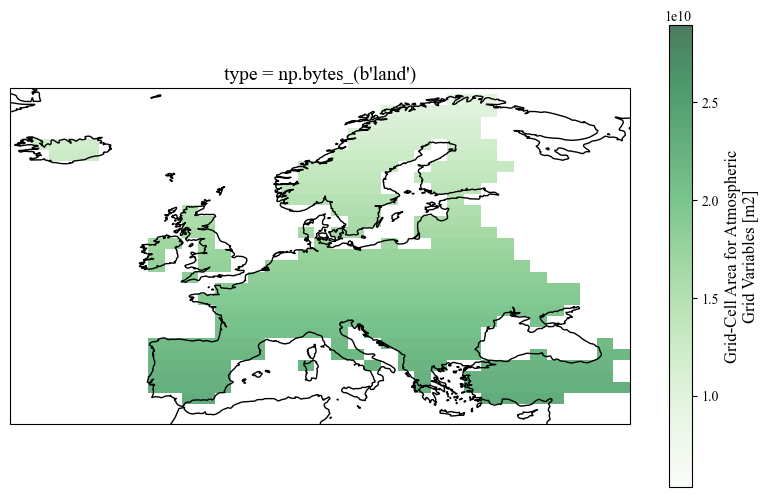

In [265]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

area_land_reg.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Greens', alpha=0.7)

ax.coastlines()
ax.set_extent([-25, 45, 34, 72], crs=ccrs.PlateCarree()) #- EUROPE
#ax.set_extent([-17, 51, -35, 37], crs=ccrs.PlateCarree()) #- AFRICA
#ax.set_extent([-170, -30, 7, 83], crs=ccrs.PlateCarree()) #- N. AMERICA
#ax.set_extent([-82, -34, -56, 13], crs=ccrs.PlateCarree()) # S AMERICA
#ax.set_extent([25, 180, -10, 80], crs=ccrs.PlateCarree()) # ASIA
#ax.set_extent([110, 180, -47, -10], crs=ccrs.PlateCarree()) #AUSTRALIA
plt.show()

In [266]:
#loop through and get the values of each zone in each dataset

zones_f = ['xAr', 'xAw', 'A', 'B', 'C', 'D', 'E', 'F']
zones_h = ['A', 'B', 'C', 'D', 'E', 'F']

historical_zones = []
future_zones = []

#get values (data) of all zones into their correct array (historical or future)
for i in range(6):
    hist_ds = datasets[i]['hist_reg_p']
    fut_ds = datasets[i]['future_reg_p']
    
    hist_zones = {z: hist_ds[z].values for z in zones_h}
    historical_zones.append(hist_zones) 

    fut_zones = {z: fut_ds[z].values for z in zones_f}
    xA_values = fut_ds['xAr'].values + fut_ds['xAw'].values
    future_zones.append(fut_zones)

In [267]:
#set up transition matrix -- using same logic as individual sankey code
transition_matrix = defaultdict(list)

for i in range(6): 
    ds_h = datasets[i]['hist_reg_p']
    ds_f = datasets[i]['future_reg_p']
    area = datasets[i]['area_land_reg_p'].values
    
#build model masks
    #Historical zone masks
    hist_z = {z: (ds_h[z] > 0) for z in zones_h}

    #Future novel mask xA = xAr ∪ xAw 
    mask_xA = (ds_f["xAr"] > 0) | (ds_f["xAw"] > 0)

    #Future zone masks, excluding xA
    fut_z = {}
    for z in zones_h:
        fut_z[z] = (ds_f[z] > 0) & (~mask_xA)

    #Add xA to future masks
    fut_z["xA"] = mask_xA
    
    #build mapping for future and historical zones
    hist_map = np.full(area.shape, '', dtype='<U3')
    fut_map = np.full(area.shape, '', dtype='<U3')

    for z in zones_h:
        hist_map[hist_z[z]] = z

    for z in zones_h + ["xA"]:
        fut_map[fut_z[z]] = z

#fill transition matrix with the mapping
    model_total_land = datasets[i]["total_area_land_reg_p"]

    for from_zone in zones_f:
        from_mask = (hist_map == from_zone).astype(int)

        for to_zone in zones_h + ["xA"]:
            to_mask = (fut_map == to_zone).astype(int)
            joint_mask = from_mask & to_mask

            land_area = np.nansum(area[joint_mask == 1])
            model_total_land = datasets[i]["total_area_land_reg_p"]
            percent = 100 * (land_area / model_total_land)

            transition_matrix[(from_zone, to_zone)].append(percent)

In [268]:
#get all land change percents for model AVERAGE
avg_transitions = {
    (from_zone, to_zone): np.mean(percent_list)
    for (from_zone, to_zone), percent_list in transition_matrix.items() }
#do not skip 0% percentages, each avg needs to be divided by 6

zones_h = ['A', 'B', 'C', 'D', 'E', 'F']
zones_f_raw = ['A', 'B', 'C', 'D', 'E', 'F', 'xAr', 'xAw']


zones_f_cleaned = [z for z in zones_f_raw if z not in ['xAr', 'xAw']]
if 'xAr' in zones_f_raw or 'xAw' in zones_f_raw:
    zones_f_cleaned = ['xA'] + zones_f_cleaned  # put xA first
zones_f_cleaned

#transition_matrix is individual percents, avg_transitions is model averages

['xA', 'A', 'B', 'C', 'D', 'E', 'F']

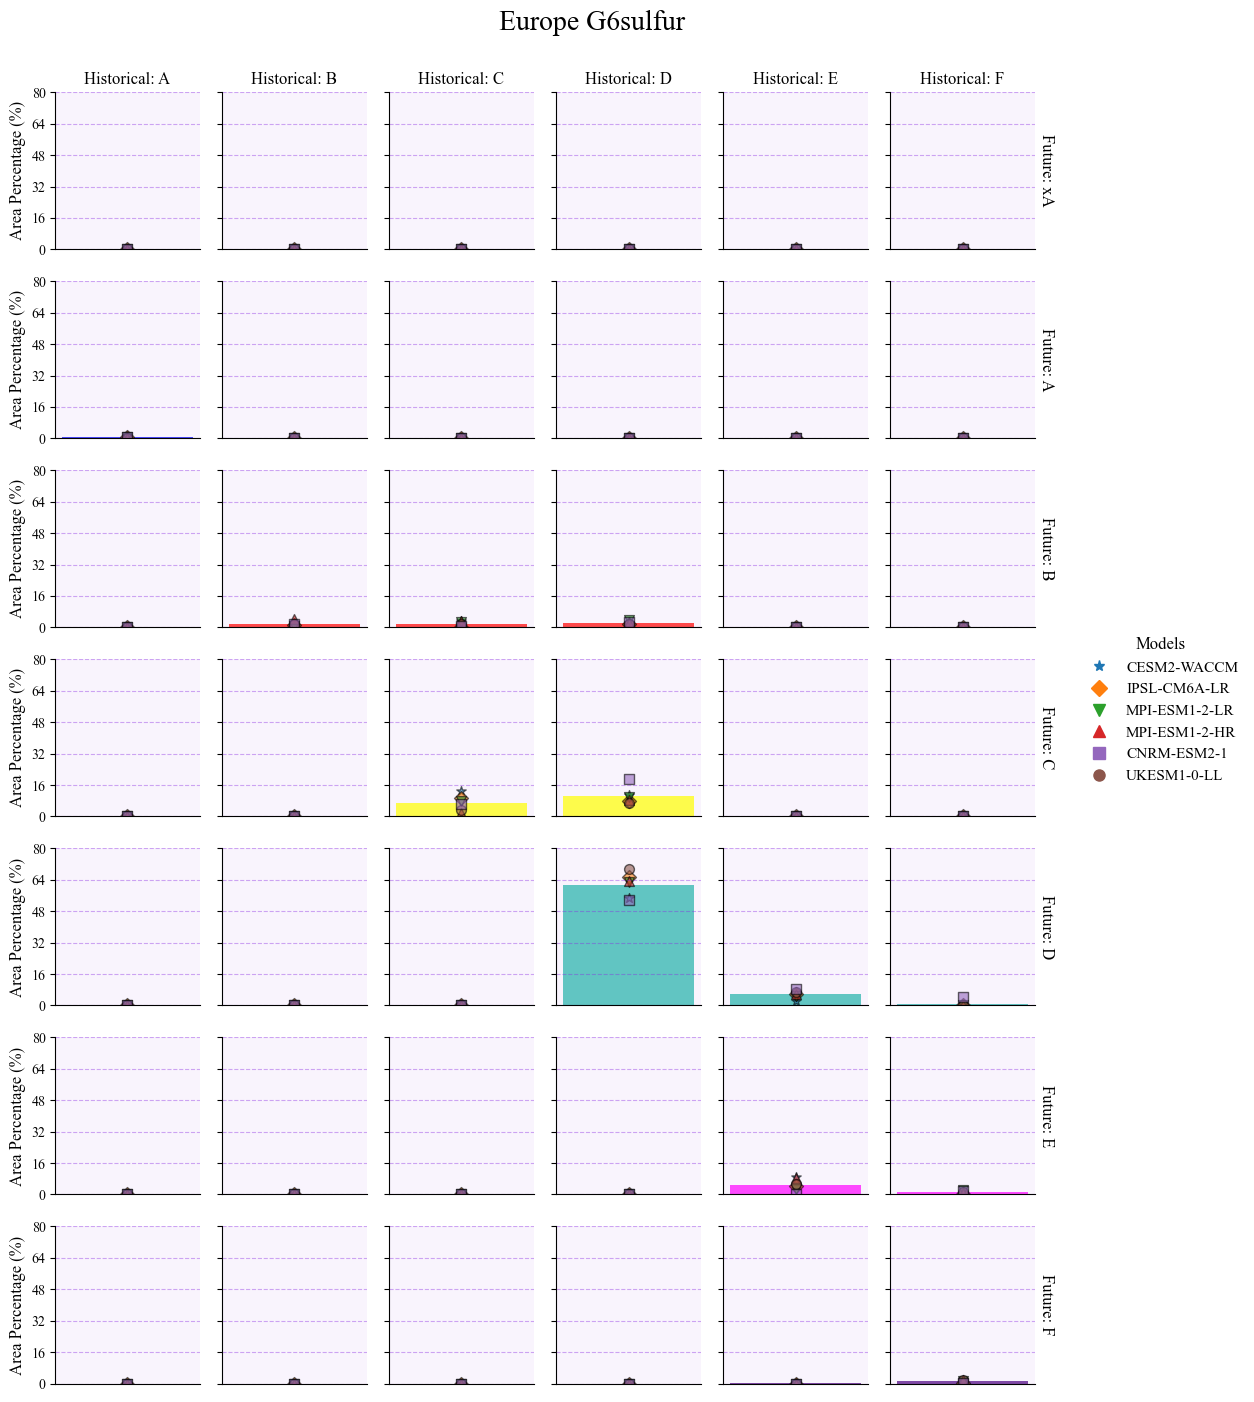

In [269]:
#set the zone order
zone_order = ['xA', 'A', 'B', 'C', 'D', 'E', 'F']
zone_order_2 = [z for z in zone_order if z != 'xA'] 

#set bar colors 
base_colors = {
    "xA": "#191970",  # Midnight Blue
    "A":  "#0000ff",  # Blue
    "B":  "#ff0000",  # Red
    "C":  "#ffff00",  # Yellow
    "D":  "#20b2aa",  # Light Sea Green
    "E":  "#ff00ff",  # Magenta
    "F":  "#4b0082",  # Indigo
}

#set model marker shapes/symbols
model_markers = {
    "CESM2-WACCM": "*",      # star
    "IPSL-CM6A-LR": "D",     # diamond
    "MPI-ESM1-2-LR": "v",    # downwards triangle
    "MPI-ESM1-2-HR": "^",    # upwards triangle
    "CNRM-ESM2-1": "s",      # square
    "UKESM1-0-LL": "o"       # circle
}

#set model marker colors
model_colors = {
    "CESM2-WACCM": "#1f77b4",  # blue
    "IPSL-CM6A-LR": "#ff7f0e", # orange
    "MPI-ESM1-2-LR": "#2ca02c",# green
    "MPI-ESM1-2-HR": "#d62728",# red
    "CNRM-ESM2-1": "#9467bd",  # purple
    "UKESM1-0-LL": "#8c564b"   # brown
}

#customize font and font size of all titles, labels, etc
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

#create dataframe of all transitions per zone per model
records = []
for (from_zone, to_zone), values in transition_matrix.items():
    for i, value in enumerate(values):
        model = model_names[i]
        records.append({
            "model": model,
            "from_zone": from_zone,
            "to_zone": to_zone,
            "area_pct": value
        })

df = pd.DataFrame(records) #make dataframe
df = df[df['from_zone'] != 'xA'] #remove historical xA

#get model averages
df_avg = df.groupby(["from_zone", "to_zone"]).agg(
    avg_pct=('area_pct', 'mean')
).reset_index()

#merge avg and individual data
df_all = df.merge(df_avg, on=["from_zone", "to_zone"], suffixes=("", "_avg"))

# ---- MATRIX LAYOUT ----
g = sns.FacetGrid(
    df_all,
    row="to_zone",
    col="from_zone",
    margin_titles=True,
    sharex=False,
    sharey=True,
    height=2,
    aspect=1,
    row_order=zone_order,
    col_order=zone_order_2
)

def draw_bars_and_points(data, **kwargs):
    to_zone = data["to_zone"].iloc[0]
    color = base_colors.get(to_zone, "gray")
    avg_val = data["avg_pct"].iloc[0]

    #create bar for avg
    plt.bar(0, avg_val, color=color, alpha=0.7)

    #overlay the model markers
    for _, row in data.iterrows():
        marker = model_markers.get(row["model"], "o")
        mcolor = model_colors.get(row["model"], "black")
        plt.scatter(
            0,
            row["area_pct"],
            marker=marker,
            facecolor=mcolor,
            edgecolor='black',
            linewidths=1,
            s=50,
            alpha=0.6
        )

    #clean up x axis, make it consistent
    plt.xticks([])
    plt.xlabel("")

g.map_dataframe(draw_bars_and_points)

#remove x ticks for all plots
for ax in g.axes.flat:
    ax.set_xticks([])
    ax.set_xticklabels([])

#add gridlines 
for ax in g.axes.flat:
    ax.grid(True, linestyle='--', alpha=0.4, color='blueviolet')

#set axis labels
g.set_axis_labels("", "Area Percentage (%)")
g.set_titles(row_template="Future: {row_name}", col_template="Historical: {col_name}")
g.set(yticks=[0, 16, 32, 48, 64, 80])
g.set(ylim=(0, None))

#create the legend (for the model markers)
import matplotlib.lines as mlines
legend_handles = [
    mlines.Line2D([], [], color=model_colors[m], marker=model_markers[m],
                  linestyle='None', markersize=8, label=m)
    for m in model_markers
]

#set the legend outside the grid (in middle)
g.fig.legend(
    handles=legend_handles,
    title="Models",
    loc='center right',
    bbox_to_anchor=(1.05, 0.5),
    frameon=False
)

#add main title (continent and scenario)
g.fig.suptitle("Europe G6sulfur", fontsize=20, y=1.0)

plt.tight_layout(rect=[0, 0, 0.9, 1])  #leave space on right for legend

#set background color w/ transparency
bg_color = to_rgba('blueviolet', alpha=0.05)
for ax in g.axes.flat:
    ax.set_facecolor(bg_color)

#plt.savefig('/Users/jaybr/OneDrive/Desktop/RESEARCH/EUROPE_SUBPLOTS_G6sulfur.png', dpi=300, bbox_inches='tight')
plt.show()

In [270]:
#sum of area_pct by model and zone - should all add up to 100
grouped_sum = df.groupby(['model', 'from_zone'])['area_pct'].sum().reset_index()
print(grouped_sum)

            model from_zone   area_pct
0     CESM2-WACCM         A   1.117950
1     CESM2-WACCM         B   1.409605
2     CESM2-WACCM         C  16.125294
3     CESM2-WACCM         D  67.268089
4     CESM2-WACCM         E  11.518642
5     CESM2-WACCM         F   2.560415
6     CESM2-WACCM       xAr   0.000000
7     CESM2-WACCM       xAw   0.000000
8     CNRM-ESM2-1         A   0.876130
9     CNRM-ESM2-1         B   1.714538
10    CNRM-ESM2-1         C   7.084206
11    CNRM-ESM2-1         D  75.289711
12    CNRM-ESM2-1         E   8.492951
13    CNRM-ESM2-1         F   6.542464
14    CNRM-ESM2-1       xAr   0.000000
15    CNRM-ESM2-1       xAw   0.000000
16   IPSL-CM6A-LR         A   0.729446
17   IPSL-CM6A-LR         B   1.274524
18   IPSL-CM6A-LR         C   9.719100
19   IPSL-CM6A-LR         D  74.925697
20   IPSL-CM6A-LR         E   9.907319
21   IPSL-CM6A-LR         F   0.798489
22   IPSL-CM6A-LR       xAr   0.000000
23   IPSL-CM6A-LR       xAw   0.000000
24  MPI-ESM1-2-HR        